In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from data import CleanedData
from models import nn
import sklearn.metrics
import torch
import sklearn.metrics

# For Adaboost
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import pickle

## Data imputing, cleaning and feature extraction

In [2]:
data = CleanedData(loc='./data/joined.csv.gz', test_ratio=0.2, impute_data=True, convert_non_numerical=True, normalize_data=True, drop_columns=['source', 'Last_Update','province','country','latitude', 'longitude'])

/opt/miniconda3/envs/cmpt353/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Splitting data to test and training data

In [3]:
X_train, y_train = data.training_data
X_test, y_test = data.test_data

In [4]:
X_train.head(5)

,age,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio,confirmed_day,in_contact,transformed_Combined_Key,transformed_sex
162090,43.482171,30.841465,75.408790,11.438557,7.903966,11.134049,9.983315,5.730074,2.917066,137.0,0.0,364.0,2.0
270476,44.000000,25.679658,85.604840,12.015021,6.755769,11.929990,9.442166,4.885724,0.519919,139.0,0.0,55.0,1.0
40245,39.795426,11.006091,78.400624,13.182344,9.069353,13.072578,10.747337,6.525087,1.635877,150.0,0.0,439.0,2.0
204748,39.857317,11.006091,78.400624,13.182344,9.069353,13.072578,10.747337,6.525087,1.635877,149.0,0.0,439.0,2.0
377355,37.000000,-11.766533,-76.604498,12.763306,9.547455,0.000000,12.722357,8.097181,4.012120,128.0,0.0,238.0,0.0


## Model 1 variations, neural network with different hyperparameters and architectures

In [5]:
# Loading up the neural netowrk models
models = []
for i in range(4):
    if i < 2:
        models.append(nn.network_1())
    else:
        models.append(nn.network_2())
    nn.load_model(models[i], f'model_{i+1}.pth')

## Accuracy of each model on training and validation data

In [6]:
for i in range(4):
    print(f'training accuracy of model_{i+1}: {nn.eval(models[i], X_train, y_train):.2f}%')
    print(f'validation accuracy of model_{i+1}: {nn.eval(models[i], X_test, y_test):.2f}%')

training accuracy of model_1: 95.17%
validation accuracy of model_1: 95.17%
training accuracy of model_2: 95.66%
validation accuracy of model_2: 95.72%
training accuracy of model_3: 94.16%
validation accuracy of model_3: 94.21%
training accuracy of model_4: 98.02%
validation accuracy of model_4: 97.94%


## Making predictions

In [7]:
models_training_preds = []
models_validation_preds = []
for i in range(4):
    models_training_preds.append(torch.argmax(torch.softmax(models[i](torch.tensor(X_train.values).float()), dim=1), dim=1))
    models_validation_preds.append(torch.argmax(torch.softmax(models[i](torch.tensor(X_test.values).float()), dim=1), dim=1))

## F-2 scores of different models only on the training dataset

In [8]:
for i in range(4):
    print(f'F_2 score of model {i+1} on training dataset: {sklearn.metrics.fbeta_score(y_train, models_training_preds[i], beta=2, average="macro"):.4f}')
    print(f'F_2 score of model {i+1} on validation dataset: {sklearn.metrics.fbeta_score(y_test, models_validation_preds[i], beta=2, average="macro"):.4f}')

F_2 score of model 1 on training dataset: 0.7094
F_2 score of model 1 on validation dataset: 0.7095
F_2 score of model 2 on training dataset: 0.7123
F_2 score of model 2 on validation dataset: 0.7129
F_2 score of model 3 on training dataset: 0.7048
F_2 score of model 3 on validation dataset: 0.7050
F_2 score of model 4 on training dataset: 0.7427
F_2 score of model 4 on validation dataset: 0.7420


In [9]:
data.encoder.classes_.tolist()

['deceased', 'hospitalized', 'nonhospitalized', 'recovered']

## Confusion matrices for the best performing model

In [10]:
conf_matrix_train = sklearn.metrics.confusion_matrix(y_train.values, models_training_preds[3])
conf_matrix_val = sklearn.metrics.confusion_matrix(y_test.values, models_validation_preds[3])

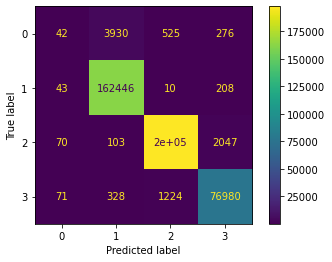

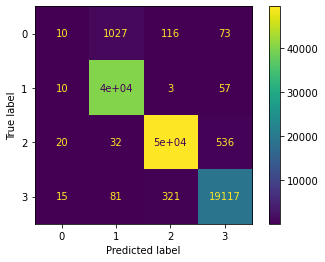

In [11]:
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_train).plot()
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_val).plot()

## Model 2: Adaboost

In [12]:
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 20),n_estimators = 25, learning_rate = 1)
with open('./data/adaboost_model.pkl', 'rb') as f:
    adaboost = pickle.load(f)

### Training Set Accuracy Score

In [13]:
adaboost.score(X_train,y_train)

0.9957544535625136

### Test set Accuracy Score

In [14]:
adaboost.score(X_test,y_test)

0.9958464160760743

### Confusion Matrices

#### Test Data Set

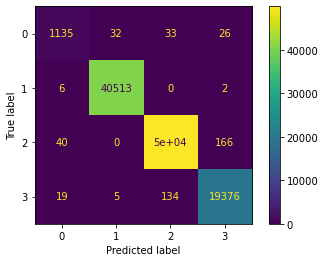

In [15]:
y_test_pred = adaboost.predict(X_test)
test_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(test_matrix).plot()

#### Training Data Set

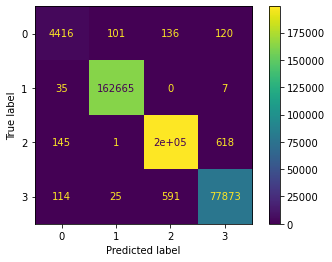

In [16]:
y_train_pred = adaboost.predict(X_train)
train_matrix = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(train_matrix).plot()

####  F-2 Scores

In [17]:
print(f'F_2 score of Adaboost on training dataset: {sklearn.metrics.fbeta_score(y_train, y_train_pred, beta=2, average="macro"):.4f}')
print(f'F_2 score of Adaboost on validation dataset: {sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=2, average="macro"):.4f}')

F_2 score of Adaboost on training dataset: 0.9785
F_2 score of Adaboost on validation dataset: 0.9792
